In [ ]:
!pip install fasttext scikit-learn pandas imbalanced-learn --quiet

import pandas as pd
import numpy as np
import fasttext
import fasttext.util
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, roc_auc_score,
    classification_report, ConfusionMatrixDisplay, RocCurveDisplay
)
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import os
import joblib

In [ ]:
fasttext.util.download_model('pl', if_exists='ignore')

'cc.pl.300.bin'

In [ ]:
ft_model = fasttext.load_model('cc.pl.300.bin')

In [ ]:
def get_ft_vector(text):
    return ft_model.get_sentence_vector(text)

In [ ]:
def prepare_data(train_path, test_path, smote=True):
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)

    X_train = np.vstack(train_df['text'].apply(get_ft_vector))
    y_train = train_df['label'].values
    X_test = np.vstack(test_df['text'].apply(get_ft_vector))
    y_test = test_df['label'].values

    if smote:
        sm = SMOTE(random_state=42)
        X_train, y_train = sm.fit_resample(X_train, y_train)

    print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
    print(f"Class distribution in train after SMOTE: {np.bincount(y_train)}")

    return X_train, y_train, X_test, y_test

In [ ]:
def train_and_evaluate_svm(X_train, y_train, X_test, y_test, param_grid, model_name="svm_model", verbose=2):
    svm = SVC(probability=True, random_state=42)
    cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

    grid_search = GridSearchCV(
        svm,
        param_grid,
        cv=cv,
        scoring='f1',
        n_jobs=-1,
        verbose=verbose
    )

    print("Start strojenia hiperparametrów (SVM)...")
    grid_search.fit(X_train, y_train)

    print("\nNajlepsze parametry:", grid_search.best_params_)
    print(f"Najlepszy wynik F1 z walidacji krzyżowej: {grid_search.best_score_:.4f}")

    best_svm = grid_search.best_estimator_

    y_pred = best_svm.predict(X_test)
    y_proba = best_svm.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)

    print("\n=== Evaluation Metrics (Final Model on Test Set) ===")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-score:  {f1:.4f}")
    print(f"ROC-AUC:   {roc_auc:.4f}")

    print("\nClassification Report:\n")
    print(classification_report(y_test, y_pred, zero_division=0))

    os.makedirs("SVM_results", exist_ok=True)

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix for SVM - The Best Variant")
    plt.savefig(f"SVM_results/{model_name}_confusion_matrix.png")
    plt.show()

    RocCurveDisplay.from_predictions(y_test, y_proba)
    plt.title("ROC Curve for SVM - The Best Variant")
    plt.savefig(f"SVM_results/{model_name}_roc_curve.png")
    plt.show()

    joblib.dump(best_svm, f"SVM_results/{model_name}.joblib")
    print(f"Model zapisany jako: SVM_results/{model_name}.joblib")


In [ ]:
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'class_weight': ['balanced']
}

In [ ]:
def run_pipeline(train_path, test_path, smote=True, param_grid=param_grid_svm):
    X_train, y_train, X_test, y_test = prepare_data(train_path, test_path, smote=smote)
    train_and_evaluate_svm(X_train, y_train, X_test, y_test, param_grid)


Train shape: (18380, 300), Test shape: (1000, 300)
Class distribution in train after SMOTE: [9190 9190]
Start strojenia hiperparametrów (SVM)...
Fitting 4 folds for each of 3 candidates, totalling 12 fits

Najlepsze parametry: {'C': 10, 'class_weight': 'balanced', 'kernel': 'linear'}
Najlepszy wynik F1 z walidacji krzyżowej: 0.8644

=== Evaluation Metrics (Final Model on Test Set) ===
Accuracy:  0.8410
Precision: 0.4459
Recall:    0.7687
F1-score:  0.5644
ROC-AUC:   0.9032

Classification Report:

              precision    recall  f1-score   support

           0       0.96      0.85      0.90       866
           1       0.45      0.77      0.56       134

    accuracy                           0.84      1000
   macro avg       0.70      0.81      0.73      1000
weighted avg       0.89      0.84      0.86      1000



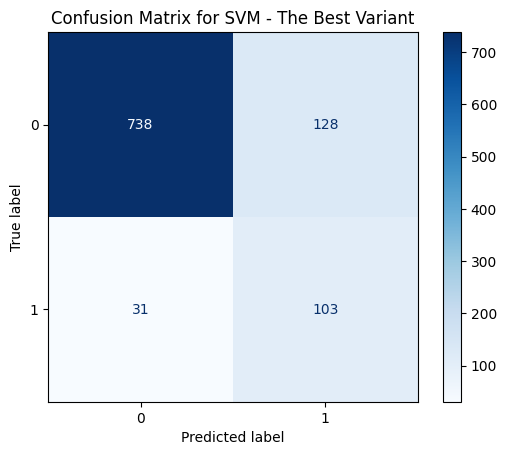

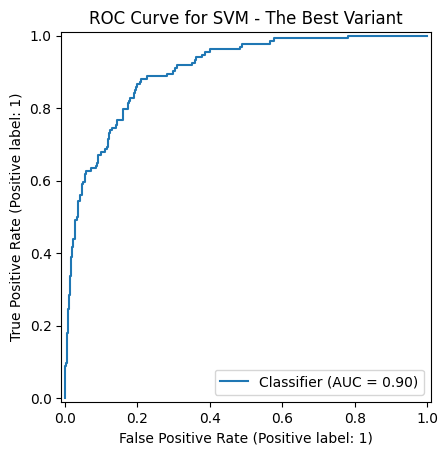

Model zapisany jako: SVM_results/svm_model.joblib


In [ ]:
run_pipeline("v1_training_variant1_raw.csv", "v1_test_variant1_raw.csv", smote=True)

Train shape: (18380, 300), Test shape: (1000, 300)
Class distribution in train after SMOTE: [9190 9190]
Start strojenia hiperparametrów (SVM)...
Fitting 4 folds for each of 3 candidates, totalling 12 fits

Najlepsze parametry: {'C': 10, 'class_weight': 'balanced', 'kernel': 'linear'}
Najlepszy wynik F1 z walidacji krzyżowej: 0.8709

=== Evaluation Metrics (Final Model on Test Set) ===
Accuracy:  0.8400
Precision: 0.4414
Recall:    0.7313
F1-score:  0.5506
ROC-AUC:   0.8786

Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.86      0.90       866
           1       0.44      0.73      0.55       134

    accuracy                           0.84      1000
   macro avg       0.70      0.79      0.73      1000
weighted avg       0.89      0.84      0.86      1000



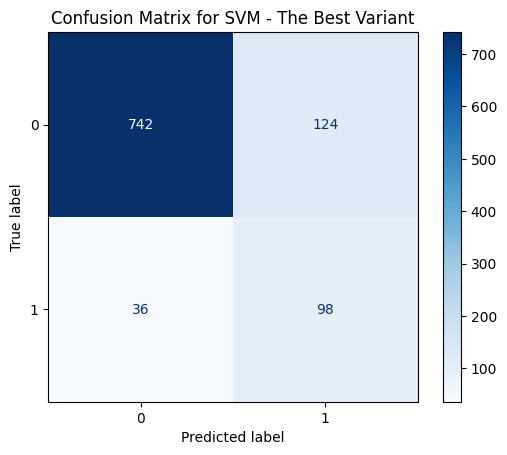

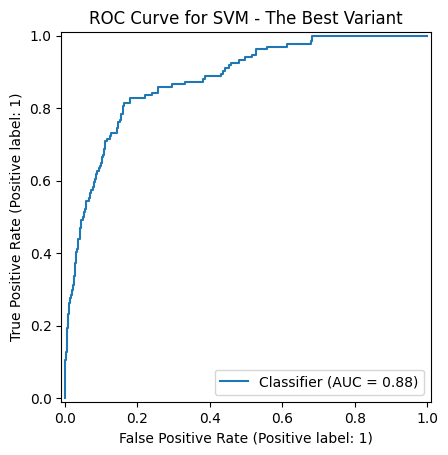

Model zapisany jako: SVM_results/svm_model.joblib


In [ ]:
run_pipeline("v1_training_variant2_light.csv", "v1_test_variant2_light.csv", smote=True)

Train shape: (18314, 300), Test shape: (999, 300)
Class distribution in train after SMOTE: [9157 9157]
Start strojenia hiperparametrów (SVM)...
Fitting 4 folds for each of 3 candidates, totalling 12 fits

Najlepsze parametry: {'C': 10, 'class_weight': 'balanced', 'kernel': 'linear'}
Najlepszy wynik F1 z walidacji krzyżowej: 0.8586

=== Evaluation Metrics (Final Model on Test Set) ===
Accuracy:  0.8208
Precision: 0.4017
Recall:    0.6866
F1-score:  0.5069
ROC-AUC:   0.8525

Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.84      0.89       865
           1       0.40      0.69      0.51       134

    accuracy                           0.82       999
   macro avg       0.67      0.76      0.70       999
weighted avg       0.87      0.82      0.84       999



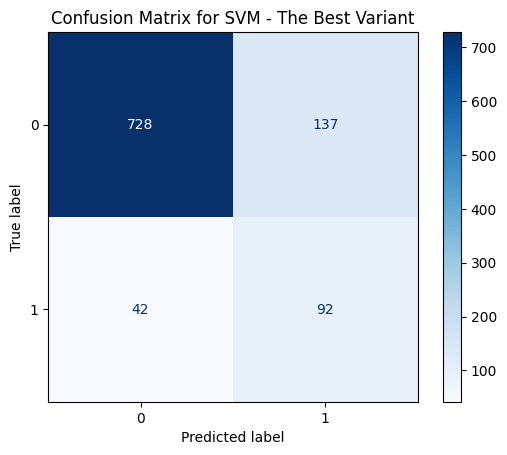

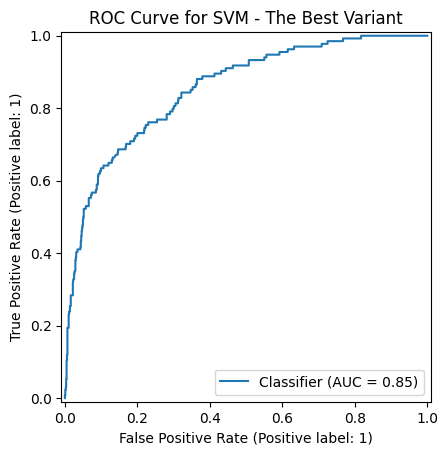

Model zapisany jako: SVM_results/svm_model.joblib


In [30]:
run_pipeline("v1_training_variant3_full.csv", "v1_test_variant3_full.csv", smote=True)